<a href="https://colab.research.google.com/github/fdabrandao/MO-book-with-AMPL/blob/dev/notebooks/01/production_planning_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```{index} single: Pyomo; variables 
```
```{index} single: Pyomo; expressions 
```
```{index} single: Pyomo; objectives 
```
```{index} single: Pyomo; constraints
```
```{index} single: Pyomo; decorators
```
```{index} single: solver; cbc
```

# A Basic AMPL Model

AMPL is an algebraic modeling language for mathematical optimization that integrates with the Python programming environment. It enables users to create optimization models consisting of decision variables, objective functions, and constraints. Pyomo provides tools to transform models, and then solve them using a variety of open-source and commercial solvers.

This notebook introduces basic elements of Pyomo common to most applications for the small [production planning problem](https://mobook.github.io/MO-book/notebooks/01/production-planning.html) introduced in a companion notebook:

* [Variables](https://pyomo.readthedocs.io/en/latest/pyomo_modeling_components/Variables.html)
* [Expressions](https://pyomo.readthedocs.io/en/latest/pyomo_modeling_components/Expressions.html)
* [Objectives](https://pyomo.readthedocs.io/en/latest/pyomo_modeling_components/Objectives.html)
* [Constraints](https://pyomo.readthedocs.io/en/latest/pyomo_modeling_components/Constraints.html)
* [SolverFactory](https://pyomo.readthedocs.io/en/stable/solving_pyomo_models.html)

The Pyomo model shown below is a direct translation of the mathematical model into basic Pyomo components. In this approach, parameter values from the mathematical model are included directly in the Pyomo model for simplicity. This method works well for problems with a small number of decision variables and constraints, but it limits the reuse of the model. Another notebook will demonstrate Pyomo features for writing models for more generic, "data-driven" applications.

This notebook also introduces the use of Python decorators to designate Pyomo expressions, objectives, and constraints. While decorators may be unfamiliar to some Python users, or even current Pyomo users, they offer a significant improvement in the readability of Pyomo model. This feature is relatively new and is available in recent versions of Pyomo.

## Preliminary Step: Install AMPL and solvers

We start by verifying the installation of Pyomo and any needed solvers. The following cell downloads a Python module that checks if Pyomo and designated solvers have been installed previously. If not, the `helper` functions perform the needed installations. These installations need to be done only once for each Python environment on a personal laptop. For Google Colab, however, a new installation must be done for each new Colab session.

In [ ]:
# install dependencies and select solver
!pip install -q amplpy matplotlib pandas

SOLVER = "cbc"

## Step 1. Import AMPL

The first step for a new Pyomo model is to import the needed components into the Python environment. The module `pyomo.environ` provides the most commonly used components for Pyomo model building. This collection of notebooks uses a consistent convention of importing `pyomo.environ` with the  `pyo` prefix.

In [ ]:
from amplpy import AMPL, tools

ampl = tools.ampl_notebook(
    modules=["cbc"], # modules to install
    license_uuid="default", # license to use
    g=globals()) # instantiate AMPL object and register magics

## Step 2. The `ConcreteModel` object

Pyomo models can be named using any standard Python variable name. In the following code cell, an instance of `ConcreteModel` is created and stored in a Python variable named `model`. It is best to use a short name since it will appear as a prefix for every Pyomo variable and constraint. `ConcreteModel` accepts an optional string argument used to title subsequent reports.

`pyo.ConcreteModel()` is used to create a model object when the problem data is known at the time of construction. Alternatively, pyo.AbstractModel() can create models where the problem data will be provided later to create specific model instances. But this is normally not needed when using the "data-driven" approach demonstrated in this collection of notebooks.


In [ ]:
# create model with optional problem title
#model = pyo.ConcreteModel("Production Planning: Version 1")

The `.display()` method displays the current content of a Pyomo model. When developing new models, this is a useful tool for verifying the model is being constructed as intended. At this stage the major components of the model are empty.

In [ ]:
#display model
#model.display()

## Step 3. Decision variables

Decision variables are created with `pyo.Var()`. The decision variables can be assigned to any valid Python identifier. Here we assign decision variables to the model instance using the Python 'dot' notation. The variable names are chosen to reflect their names in the mathematical model. 

`pyo.Var()` accepts optional keyword arguments. The most commonly used keyword arguments are:

* `domain` specifies a set of values for a decision variable. By default, the domain is the set of all real numbers. Other commonly used domains are `pyo.NonNegativeReals`, `pyo.NonNegativeIntegers`, and `pyo.Binary`.

* `bounds` is an optional keyword argument to specify a tuple containing values for the lower and upper bounds. It is good modeling practice to specify any known and fixed bounds on the decision variables. `None` can be used as a placeholder if one of the two bounds is unknown. Specifying the bounds as `(0, None)` is equivalent to specifying the domain as `pyo.NonNegativeReals`.

The use of the optional keywords is shown in the following cell. Displaying the model shows the value of the decision variables is not yet known.

In [ ]:
%%ampl_eval
# create decision variables
var x_M >= 0;
var x_A >= 0, <= 80;
var x_B >= 0, <= 100;

var y_U >= 0, <= 40;
var y_V >= 0;

In [ ]:
%%ampl_eval
# display updated model
show;


variables:   x_A   x_B   x_M   y_U   y_V


## Step 4. Expressions

Pyomo expressions are mathematical formulas involving the decision variables. The following cell creates expressions for revenue and cost that are assigned to `model.revenue` and `model.cost`, respectively.

In [ ]:
%%ampl_eval
# create expressions
var revenue = 270 * y_U + 210 * y_V;
var cost = 10 * x_M + 50 * x_A + 40 * x_B;

# expressions can be printed
display revenue;
display cost;

revenue = 0

cost = 0



In [ ]:
%%ampl_eval
expand;
show;


variables:   cost   revenue   x_A   x_B   x_M   y_U   y_V


## Step 5. Objective

The objective for this example is to maximize profit which is given by the difference between revenue and cost. There are two ways this objective could be specified in Pyomo.

The first method is to use `pyo.Objective()` where the expression to be optimized is assigned with the `expr` keyword and the type of objective is assigned with the `sense` keyword.

    model.profit = pyo.Objective(expr = model.revenue - model.cost, sense = pyo.maximize)
    
Recent releases of Pyomo provide a second method that uses Python [decorators](https://peps.python.org/pep-0318/) to specify an objective. With a decorator, the same objective is written as

    @model.Objective(sense = pyo.maximize)
    def profit(model):
        return model.revenue - model.cost

Python decorators modify the behavior of the function defined in the next line.  In this case, the decorator `@model.Objective()` modifies the behavior of `profit()` so that it returns an expression for the profit to Pyomo. The keyword `sense` sets the type of objective, which can either be to maximize or minimize the value returned by the objective function. The function `profit()`, after being decorated, takes the Pyomo model as its first argument and adds its name to the model attributes.

In effect, Pyomo decorators are tags that insert functions into a Pyomo model to serve as expressions, objectives, or constraints. Decorators can improve the readability and maintainability of more complex models. They also simplify the syntax for creating other Pyomo objects expressions, constraints, and other optimization-related elements.

In [ ]:
%%ampl_eval

maximize profit: revenue - cost;

show;


variables:   cost   revenue   x_A   x_B   x_M   y_U   y_V

objective:   profit


## Step 6. Constraints

Constraints are logical relationships between expressions that define the range of feasible solutions in an optimization problem. A constraint consists of two expressions separated by one of the logical relationships. The logical relationships can be equality (`==`), less-than (`<=`), or greater-than (`>=`). 

Constraints can be created with `pyo.Constraint()`. The constraint is passed as a keyword argument `expr` to `pyo.Constraint()`. For this application the constraints could be expressed as  

    model.raw_materials = pyo.Constraint(expr = 10 * model.y_U + 9 * model.y_V <= model.x_M)
    model.labor_A = pyo.Constraint(expr = 2 * model.y_U + 1 * model.y_V <= model.x_A)
    model.labor_B = pyo.Constraint(expr = 1 * model.y_U + 1 * model.y_V <= model.x_B)
    
Alternatively, the `@model.Constraint()` decorator 'tags' the output of the following function as a constraint. For the present example, the constraints are expressed with decorators below. This collection of notebooks uses decorators whenever possible to improve the readability and maintainability of Pyomo models.

In [ ]:
%%ampl_eval
s.t. raw_materials: 10 * y_U + 9 * y_V <= x_M;
s.t. labor_A: 2 * y_U + 1 * y_V <= x_A;
s.t. labor_B: 1 * y_U + 1 * y_V <= x_B;

expand;
show;

maximize profit:
	revenue - cost;

subject to raw_materials:
	-x_M + 10*y_U + 9*y_V <= 0;

subject to labor_A:
	-x_A + 2*y_U + y_V <= 0;

subject to labor_B:
	-x_B + y_U + y_V <= 0;


variables:   cost   revenue   x_A   x_B   x_M   y_U   y_V

constraints:   labor_A   labor_B   raw_materials

objective:   profit


## Step 7. Solve the model

With the model now fully specified, the next step is to compute a solution. A solver object is created with `SolverFactory` then applied to the model as shown in the following cell. Here we have chosen to use the open source [COIN-OR Cbc](https://github.com/coin-or/Cbc)  ("COIN-OR branch and cut") solver for mixed integer linear programming. There are other suitable solvers such as the open-source [HiGHS](https://highs.dev/), or commercial solvers such as CPLEX, Gurobi, and Mosek.

The optional keyword `tee=True` causes the solver to print its output to the output. This can be useful for debugging problems that arise when developing a new model.

In [ ]:
ampl.option["solver"] = SOLVER
ampl.solve()

cbc 2.10.7: cbc 2.10.7: optimal solution; objective 2400
0 simplex iterations


## Step 8. Reporting the solution

The final step in most applications is to report the solution in a suitable format. For this example, we demonstrate simple tabular and graphic reports using the Pandas library. For an overview of other ways to report and visualize the solutions, see also the appendix of [this notebook](../04/gasoline-distribution.ipynb).

### Pyomo `pprint()`

Pyomo provides several functions for creating model reports that contain solution values. The `pprint()` method can be applied to the entire model, or to individual components of the model, as shown in the following cells.

In [ ]:
# display the whole model
#model.pprint()

In [ ]:
# display a component of the model
ampl.display("profit")

profit = 2400



### Accessing solution values with `pyo.value()`

After a solution to a Pyomo model has been successfully computed, values for the objective, expressions, and decisions variables can be accessed with `pyo.value()`.

In [ ]:
ampl.obj["profit"].value()

2400.0

When combined with [Python f strings](https://docs.python.org/3/tutorial/inputoutput.html), `pyo.value()` provides a convenient means of creating formatted reports.

In [ ]:
print(f" Profit = {ampl.obj['profit'].value(): 9.2f}")
print(f"Revenue = {ampl.var['revenue'].value(): 9.2f}")
print(f"   Cost = {ampl.var['cost'].value(): 9.2f}")

 Profit =   2400.00
Revenue =  16800.00
   Cost =  14400.00


Pyomo provides a shortcut notation for accessing solution. After a solution has been computed, a function with the same name as decision variable is created that will report the solution value. 

In [ ]:
#print("x_A =", model.x_A())
#print("x_B =", model.x_B())
#print("x_M =", model.x_M())

### Creating reports with Pandas

Pandas is an open-source library for working with data in Python and is widely used in the data science community. Here we use a Pandas `Series()` object to hold and display solution data. We can then visualize them using the matplotlib library, for instance with a bar chart.

In [ ]:
import pandas as pd

# create pandas series for production and raw materials
production = pd.Series({
    "U": ampl.var['y_U'].value(),
    "V": ampl.var['y_V'].value(),
})

raw_materials = pd.Series({
    "A": ampl.var['x_A'].value(),
    "B": ampl.var['x_B'].value(),
    "M": ampl.var['x_M'].value(),
})

# display pandas series
display(production)
display(raw_materials)

U     0.0
V    80.0
dtype: float64

A     80.0
B     80.0
M    720.0
dtype: float64

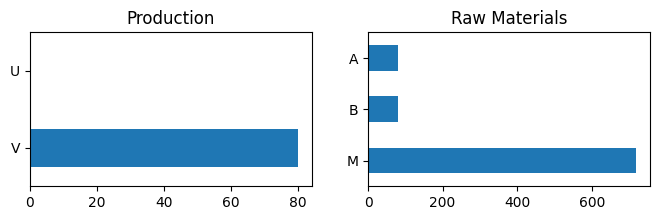

In [ ]:
import matplotlib.pyplot as plt

# create grid of subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 2))

# show pandas series as horizontal bar plots
production.plot(ax=ax[0], kind="barh", title="Production")
raw_materials.plot(ax=ax[1], kind="barh", title="Raw Materials")

# show vertical axis in descending order
ax[0].invert_yaxis()
ax[1].invert_yaxis()

Mention .mod file (model isolation) and pure Python execution?

In [ ]:
%%writefile production_planning_basic.mod

# decision variables
var x_M >= 0;
var x_A >= 0, <= 80;
var x_B >= 0, <= 100;

var y_U >= 0, <= 40;
var y_V >= 0;

# auxiliary variables
var revenue = 270 * y_U + 210 * y_V;
var cost = 10 * x_M + 50 * x_A + 40 * x_B;

# objective
maximize profit: revenue - cost;

# constraints
s.t. raw_materials: 10 * y_U + 9 * y_V <= x_M;
s.t. labor_A: 2 * y_U + 1 * y_V <= x_A;
s.t. labor_B: 1 * y_U + 1 * y_V <= x_B;

Overwriting production_planning_basic.mod


In [ ]:
# Create AMPL instance and load the model
ampl = AMPL()
ampl.read("production_planning_basic.mod")

# Select a solver and solve the problem
ampl.option["solver"] = SOLVER
ampl.solve()

cbc 2.10.7: cbc 2.10.7: optimal solution; objective 2400
0 simplex iterations
